In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from tqdm.notebook import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [17]:
USE_GPU = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_GPU else "cpu")
print(f"Используемое устройство: {DEVICE}")

BASE_DATA_PATH = Path("/kaggle/input/nabirds")
IMAGES_PATH = BASE_DATA_PATH / "images"
INFO_PATH = BASE_DATA_PATH

BATCH_SIZE = 16
NUM_EPOCHS_TOTAL = 50
LEARNING_RATE = 2e-05
NUM_EPOCHS_WARMUP = 5 
NUM_WORKERS = 2

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if USE_GPU:
    torch.cuda.manual_seed_all(RANDOM_SEED)

Используемое устройство: cuda


In [18]:
print("\n1.1 Загрузка Метаданных...")
try:
    images_df = pd.read_csv(INFO_PATH / 'images.txt', sep=' ', names=['image_id', 'filepath'])
    image_class_labels_df = pd.read_csv(INFO_PATH / 'image_class_labels.txt', sep=' ', names=['image_id', 'class_id'])
    
    class_ids_list = []
    class_names_list = []
    try:
        with open(INFO_PATH / 'classes.txt', 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line: 
                    parts = line.split(' ', 1) 
                    class_ids_list.append(int(parts[0]))
                    class_names_list.append(parts[1])
        classes_df = pd.DataFrame({'class_id': class_ids_list, 'class_name': class_names_list})
        print("classes.txt успешно загружен с обработкой.")
    except Exception as e_classes:
        print(f"Ошибка при загрузке classes.txt: {e_classes}")
        raise e_classes

    train_test_split_df = pd.read_csv(INFO_PATH / 'train_test_split.txt', sep=' ', names=['image_id', 'is_training_image'])
    bounding_boxes_df = pd.read_csv(INFO_PATH / 'bounding_boxes.txt', sep=' ', names=['image_id', 'x', 'y', 'width', 'height'])

    print(f"Загружено images_df: {images_df.shape}")
    print(f"Загружено image_class_labels_df: {image_class_labels_df.shape}")
    print(f"Загружено classes_df: {classes_df.shape}")
    print(f"Загружено train_test_split_df: {train_test_split_df.shape}")
    print(f"Загружено bounding_boxes_df: {bounding_boxes_df.shape}")

except Exception as e:
    print(f"Ошибка при загрузке метаданных: {e}")
    raise


1.1 Загрузка Метаданных...
classes.txt успешно загружен с пользовательской обработкой.
Загружено images_df: (48562, 2)
Загружено image_class_labels_df: (48562, 2)
Загружено classes_df: (1011, 2)
Загружено train_test_split_df: (48562, 2)
Загружено bounding_boxes_df: (48562, 5)


In [19]:
print("\n1.2 Объединение Метаданных...")
df = images_df.merge(image_class_labels_df, on='image_id')
df = df.merge(classes_df, on='class_id')
df = df.merge(train_test_split_df, on='image_id')
df = df.merge(bounding_boxes_df, on='image_id')

df['full_path'] = df['filepath'].apply(lambda x: IMAGES_PATH / x)

sample_paths = df['full_path'].sample(5)
for path in sample_paths:
    if not path.exists():
        print(f"ПРЕДУПРЕЖДЕНИЕ: Файл не найден: {path}")

print(f"Объединенный DataFrame df: {df.shape}")
print(df.head())


1.2 Объединение Метаданных...
Объединенный DataFrame df: (48562, 10)
                               image_id  \
0  0000139e-21dc-4d0c-bfe1-4cae3c85c829   
1  0000d9fc-4e02-4c06-a0af-a55cfb16b12b   
2  00019306-9d83-4334-b255-a447742edce3   
3  0001afd4-99a1-4a67-b940-d419413e23b3   
4  000332b8-997c-4540-9647-2f0a8495aecf   

                                    filepath  class_id  \
0  0817/0000139e21dc4d0cbfe14cae3c85c829.jpg       817   
1  0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg       860   
2  0900/000193069d834334b255a447742edce3.jpg       900   
3  0645/0001afd499a14a67b940d419413e23b3.jpg       645   
4  0929/000332b8997c454096472f0a8495aecf.jpg       929   

                           class_name  is_training_image    x    y  width  \
0                        Oak Titmouse                  0   83   59    128   
1                            Ovenbird                  0  328   88    163   
2                    Savannah Sparrow                  0  174  367    219   
3  Eared Grebe

In [20]:
print("\n1.3 Краткий Анализ Данных...")
num_classes = df['class_id'].nunique()
print(f"Общее количество уникальных классов (видов птиц): {num_classes}")

print(f"Топ-5 самых частых классов:\n{df['class_name'].value_counts().head()}")
print(f"Топ-5 самых редких классов:\n{df['class_name'].value_counts().tail()}")


1.3 Краткий Анализ Данных...
Общее количество уникальных классов (видов птиц): 555
Топ-5 самых частых классов:
class_name
Eastern Phoebe                  120
Brown-headed Cowbird (Male)     120
Black-throated Green Warbler    120
Barred Owl                      120
Western Scrub-Jay               120
Name: count, dtype: int64
Топ-5 самых редких классов:
class_name
Fox Sparrow (Thick-billed/Slate-colored)    25
Snow Bunting (Breeding adult)               24
Red-throated Loon (Breeding)                23
Purple Gallinule (Immature)                 21
Dark-eyed Junco (White-winged)              13
Name: count, dtype: int64


In [21]:
print("\n1.4 Преобразование class_id...")
unique_class_ids = sorted(df['class_id'].unique())
class_id_to_label = {class_id: i for i, class_id in enumerate(unique_class_ids)}
label_to_class_id = {i: class_id for class_id, i in class_id_to_label.items()}

label_to_class_name = {
    class_id_to_label[cid]: name 
    for cid, name in zip(classes_df['class_id'], classes_df['class_name'])
    if cid in class_id_to_label
}

df['label'] = df['class_id'].map(class_id_to_label)
NUM_CLASSES_MODEL = len(unique_class_ids)
print(f"Количество классов для модели (0-индексированные): {NUM_CLASSES_MODEL}")

if len(label_to_class_name) != NUM_CLASSES_MODEL:
    print(f"ПРЕДУПРЕЖДЕНИЕ: Расхождение в количестве классов!")
    print(f"NUM_CLASSES_MODEL (из df): {NUM_CLASSES_MODEL}")
    print(f"Количество элементов в label_to_class_name: {len(label_to_class_name)}")

Количество классов для модели (0-индексированные): 555


In [22]:
print("\n1.5 Разделение Данных...")
train_df_full = df[df['is_training_image'] == 1].copy()
test_df = df[df['is_training_image'] == 0].copy()

train_df, val_df = train_test_split(
    train_df_full,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=train_df_full['label']
)

print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер валидационной выборки: {len(val_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")


1.5 Разделение Данных...
Размер обучающей выборки: 19143
Размер валидационной выборки: 4786
Размер тестовой выборки: 24633


In [23]:
print("\n1.6 Создание PyTorch Dataset...")
class NABirdsDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, use_bounding_box=False):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.use_bounding_box = use_bounding_box

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_info = self.dataframe.iloc[idx]
        img_path = img_info['full_path']
        
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Ошибка: Файл не найден {img_path}")
            return None, None 
        except Exception as e:
            print(f"Ошибка загрузки изображения {img_path}: {e}")
            return None, None

        if self.use_bounding_box:
            x, y, w, h = img_info['x'], img_info['y'], img_info['width'], img_info['height']
            image = image.crop((x, y, x + w, y + h))

        label = img_info['label']

        if self.transform:
            image = self.transform(image)
        
        return image, label


1.6 Создание PyTorch Dataset...


In [24]:
print(f"\n1.7 Определение Трансформаций...")
IMAGE_SIZE = 384
MODEL_MEAN = (0.485, 0.456, 0.406)
MODEL_STD = (0.229, 0.224, 0.225)
INTERPOLATION_MODE = T.InterpolationMode.BICUBIC

train_transforms = T.Compose([
    T.Resize((IMAGE_SIZE + 96, IMAGE_SIZE + 96), interpolation=INTERPOLATION_MODE),
    T.RandomCrop(IMAGE_SIZE), # (384, 384)
    T.RandomHorizontalFlip(p=0.5),
    T.TrivialAugmentWide(interpolation=INTERPOLATION_MODE, num_magnitude_bins=31),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=MODEL_MEAN, std=MODEL_STD),
    T.RandomErasing(p=0.4, scale=(0.02, 0.25), ratio=(0.3, 3.3), value='random')
])

val_test_transforms = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=INTERPOLATION_MODE),
    T.ToTensor(),
    T.Normalize(mean=MODEL_MEAN, std=MODEL_STD)
])

train_dataset = NABirdsDataset(train_df, IMAGES_PATH, transform=train_transforms, use_bounding_box=True)
val_dataset = NABirdsDataset(val_df, IMAGES_PATH, transform=val_test_transforms)
test_dataset = NABirdsDataset(test_df, IMAGES_PATH, transform=val_test_transforms)

print(f"Создан train_dataset: {len(train_dataset)} семплов")
print(f"Создан val_dataset: {len(val_dataset)} семплов")
print(f"Создан test_dataset: {len(test_dataset)} семплов")

def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch:
        return torch.Tensor(), torch.Tensor() 
    return torch.utils.data.dataloader.default_collate(batch)


1.7 Определение Трансформаций...
Создан train_dataset: 19143 семплов
Создан val_dataset: 4786 семплов
Создан test_dataset: 24633 семплов


In [25]:
print("\n1.8 Создание DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True if USE_GPU else False, collate_fn=collate_fn_skip_none)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if USE_GPU else False, collate_fn=collate_fn_skip_none)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if USE_GPU else False, collate_fn=collate_fn_skip_none)

print(f"Создан train_loader: {len(train_loader)} батчей")
print(f"Создан val_loader: {len(val_loader)} батчей")
print(f"Создан test_loader: {len(test_loader)} батчей")


1.8 Создание DataLoaders...
Создан train_loader: 1197 батчей
Создан val_loader: 300 батчей
Создан test_loader: 1540 батчей



1.9 Визуализация Семплов Данных...


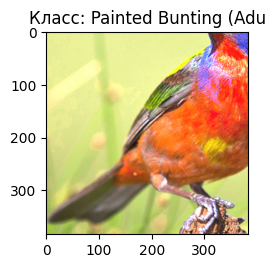

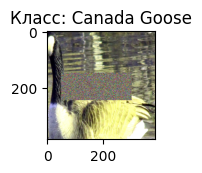

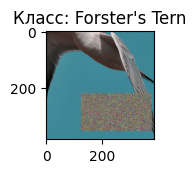

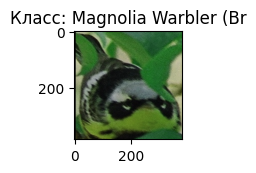

In [11]:
print("\n1.9 Визуализация Семплов Данных...")
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

try:
    example_batch_images, example_batch_labels = next(iter(train_loader))
    if example_batch_images.nelement() > 0:
        plt.figure(figsize=(12, 8))
        for i in range(min(4, len(example_batch_images))):
            ax = plt.subplot(1, 4, i + 1)
            class_name_str = label_to_class_name.get(example_batch_labels[i].item(), "Неизвестный класс")
            imshow(example_batch_images[i], title=f"Класс: {class_name_str[:20]}")
        plt.show()
    else:
        print("Не удалось загрузить батч для визуализации (возможно, все файлы в первом батче были пропущены).")
except StopIteration:
    print("Train loader пуст, невозможно визуализировать.")
except Exception as e:
    print(f"Ошибка при визуализации: {e}")

In [12]:
print("\n--- ФАЗА 2: РАЗРАБОТКА И ОБУЧЕНИЕ МОДЕЛИ ---")

#print(timm.list_models(''))

print("\n2.1 Определение Архитектуры Модели...")
model_raw = timm.create_model('swinv2_large_window12to24_192to384', pretrained=True, num_classes=NUM_CLASSES_MODEL, drop_path_rate=0.2)

if torch.cuda.device_count() > 1:
    print(f"Используется {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model_raw)
else:
    print("Используется 1 GPU или CPU.")
    model = model_raw

model = model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
print("Архитектура модели :")
print(model_raw.default_cfg)


--- ФАЗА 2: РАЗРАБОТКА И ОБУЧЕНИЕ МОДЕЛИ ---
['aimv2_1b_patch14_224', 'aimv2_1b_patch14_336', 'aimv2_1b_patch14_448', 'aimv2_3b_patch14_224', 'aimv2_3b_patch14_336', 'aimv2_3b_patch14_448', 'aimv2_huge_patch14_224', 'aimv2_huge_patch14_336', 'aimv2_huge_patch14_448', 'aimv2_large_patch14_224', 'aimv2_large_patch14_336', 'aimv2_large_patch14_448', 'bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coa

model.safetensors:   0%|          | 0.00/814M [00:00<?, ?B/s]

Используется 2 GPU!
Архитектура модели :
{'url': 'https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12to24_192to384_22kto1k_ft.pth', 'hf_hub_id': 'timm/swinv2_large_window12to24_192to384.ms_in22k_ft_in1k', 'architecture': 'swinv2_large_window12to24_192to384', 'tag': 'ms_in22k_ft_in1k', 'custom_load': False, 'input_size': (3, 384, 384), 'fixed_input_size': True, 'interpolation': 'bicubic', 'crop_pct': 1.0, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': (12, 12), 'first_conv': 'patch_embed.proj', 'classifier': 'head.fc', 'license': 'mit'}


In [29]:
print("\n2.2 Определение Функции Потерь и Оптимизатора...")
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

if isinstance(model, nn.DataParallel):
    optimizer = optim.AdamW(model.module.parameters(), lr=LEARNING_RATE, weight_decay=1e-08)
else:
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-08) 

if NUM_EPOCHS_WARMUP > 0 and NUM_EPOCHS_TOTAL > NUM_EPOCHS_WARMUP:
    warmup_scheduler = optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=0.01,
        end_factor=1.0,
        total_iters=NUM_EPOCHS_WARMUP 
    )
    main_scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=NUM_EPOCHS_TOTAL - NUM_EPOCHS_WARMUP,
        eta_min=2e-07
    )
    scheduler = optim.lr_scheduler.SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, main_scheduler],
        milestones=[NUM_EPOCHS_WARMUP] 
    )
    print(f"Используется SequentialLR: Warmup на {NUM_EPOCHS_WARMUP} эпох (LR от {LEARNING_RATE*0.01:.1e} до {LEARNING_RATE:.1e}), "
          f"затем CosineAnnealingLR на {NUM_EPOCHS_TOTAL - NUM_EPOCHS_WARMUP} эпох (до {2e-07:.1e}).")
else:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=NUM_EPOCHS_TOTAL,
        eta_min=2e-07
    )
    print(f"Используется CosineAnnealingLR без warmup на {NUM_EPOCHS_TOTAL} эпох (LR от {LEARNING_RATE:.1e} до {2e-07:.1e}).")


2.2 Определение Функции Потерь и Оптимизатора...
Используется SequentialLR: Warmup на 5 эпох (LR от 2.0e-07 до 2.0e-05), затем CosineAnnealingLR на 45 эпох (до 2.0e-07).


In [ ]:
print("\n2.3 Запуск Цикла Обучения и Валидации...")

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=NUM_EPOCHS_TOTAL, device=DEVICE, early_stopping_patience=15):
    if isinstance(model, torch.nn.DataParallel):
        best_model_wts = model.module.state_dict()
    else:
        best_model_wts = model.state_dict()
    
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    epochs_no_improve = 0 

    for epoch in range(num_epochs):
        print(f'\nЭпоха {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloader, desc=f"{phase} phase"):
                if inputs.nelement() == 0:
                    continue

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
            
            if total_samples == 0:
                print(f"Нет данных для обработки в фазе {phase} эпохи {epoch+1}")
                epoch_loss = 0
                epoch_acc = 0
            else:
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples

            print(f'{phase} Потери: {epoch_loss:.4f} Точность: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                if scheduler:
                     scheduler.step() 
            else: # phase == 'val'
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                if epoch_acc > best_acc:
                    print(f"Валидационная точность улучшилась с {best_acc:.4f} до {epoch_acc:.4f}.")
                    best_acc = epoch_acc
                    if isinstance(model, torch.nn.DataParallel):
                        best_model_wts = model.module.state_dict()
                    else:
                        best_model_wts = model.state_dict()
                    # ---------------------------------------------------------
                    torch.save(best_model_wts, '/kaggle/working/best_nabirds_model.pth')
                    print(f"Лучшая модель сохранена с val_acc: {best_acc:.4f}")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f"Валидационная точность не улучшилась. Эпох без улучшения: {epochs_no_improve}/{early_stopping_patience}")

        if epochs_no_improve >= early_stopping_patience:
            print(f'\nРанняя остановка! Валидационная точность не улучшалась {early_stopping_patience} эпох подряд.')
            print(f'Загружаем лучшую модель с val_acc: {best_acc:.4f}')
            if isinstance(model, torch.nn.DataParallel):
                model.module.load_state_dict(best_model_wts)
            else:
                model.load_state_dict(best_model_wts)
            # -------------------------------------------------------
            return model, history
            
    print(f'\nОбучение завершено (прошли все {num_epochs} эпох). Лучшая точность на валидации: {best_acc:.4f}')
    
    if isinstance(model, torch.nn.DataParallel):
        model.module.load_state_dict(best_model_wts)
    else:
        model.load_state_dict(best_model_wts)
    # -------------------------------------------------------
    return model, history

EPOCHS = 50
PATIENCE = 5
print(f"Запускаю обучение на {EPOCHS} эпох (или до {PATIENCE} эпох без улучшения валидационной точности)...")

model_ft, history = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=EPOCHS,
    early_stopping_patience=PATIENCE
)


2.3 Запуск Цикла Обучения и Валидации...
Запускаю обучение на 50 эпох (или до 5 эпох без улучшения валидационной точности)...

Эпоха 1/50
----------


train phase:   0%|          | 0/3191 [00:00<?, ?it/s]

train Потери: 6.3554 Точность: 0.0023


val phase:   0%|          | 0/798 [00:00<?, ?it/s]

val Потери: 6.3105 Точность: 0.0027
Валидационная точность улучшилась с 0.0000 до 0.0027.
Лучшая модель сохранена с val_acc: 0.0027

Эпоха 2/50
----------


train phase:   0%|          | 0/3191 [00:00<?, ?it/s]

train Потери: 4.2091 Точность: 0.3118


val phase:   0%|          | 0/798 [00:00<?, ?it/s]

val Потери: 2.0022 Точность: 0.7144
Валидационная точность улучшилась с 0.0027 до 0.7144.
Лучшая модель сохранена с val_acc: 0.7144

Эпоха 3/50
----------


train phase:   0%|          | 0/3191 [00:00<?, ?it/s]

train Потери: 2.2014 Точность: 0.6755


val phase:   0%|          | 0/798 [00:00<?, ?it/s]

val Потери: 1.6189 Точность: 0.8224
Валидационная точность улучшилась с 0.7144 до 0.8224.
Лучшая модель сохранена с val_acc: 0.8224

Эпоха 4/50
----------


train phase:   0%|          | 0/3191 [00:00<?, ?it/s]

In [ ]:
print("\n2.4 Визуализация Результатов Обучения...")
if history:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.title('График Потерь')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.title('График Точности')
    plt.tight_layout()
    plt.show()
else:
    print("История обучения пуста, графики не будут построены.")


In [ ]:

print("\n2.5 Оценка Модели на Тестовой Выборке...")
def evaluate_model(model, test_loader, device=DEVICE):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Тестирование"):
            if inputs.nelement() == 0: continue

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    if not all_labels or not all_preds:
        print("Не удалось получить предсказания на тестовой выборке.")
        return None, None

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'\nТочность на тестовой выборке: {accuracy:.4f}')
    
    print("\nClassification Report:")
    target_names = [label_to_class_name[i] for i in sorted(label_to_class_name.keys())]
    unique_labels_in_report = sorted(list(set(all_labels) | set(all_preds)))
    report_target_names = [label_to_class_name.get(l, f"Class_{l}") for l in unique_labels_in_report]
    
    print(classification_report(all_labels, all_preds, labels=unique_labels_in_report, target_names=report_target_names, zero_division=0))
    
    return all_labels, all_preds

if 'model_ft' in locals():
    test_labels, test_preds = evaluate_model(model_ft, test_loader)
else:
    print("Модель не была обучена в этой сессии. Загрузите веса или запустите обучение.")
